# House price prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

from my_funcs import *

# Data loading

In [3]:
house_data = pd.read_csv("train.csv", index_col="Id")
test_data = pd.read_csv("test.csv", index_col="Id")

In [4]:
house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


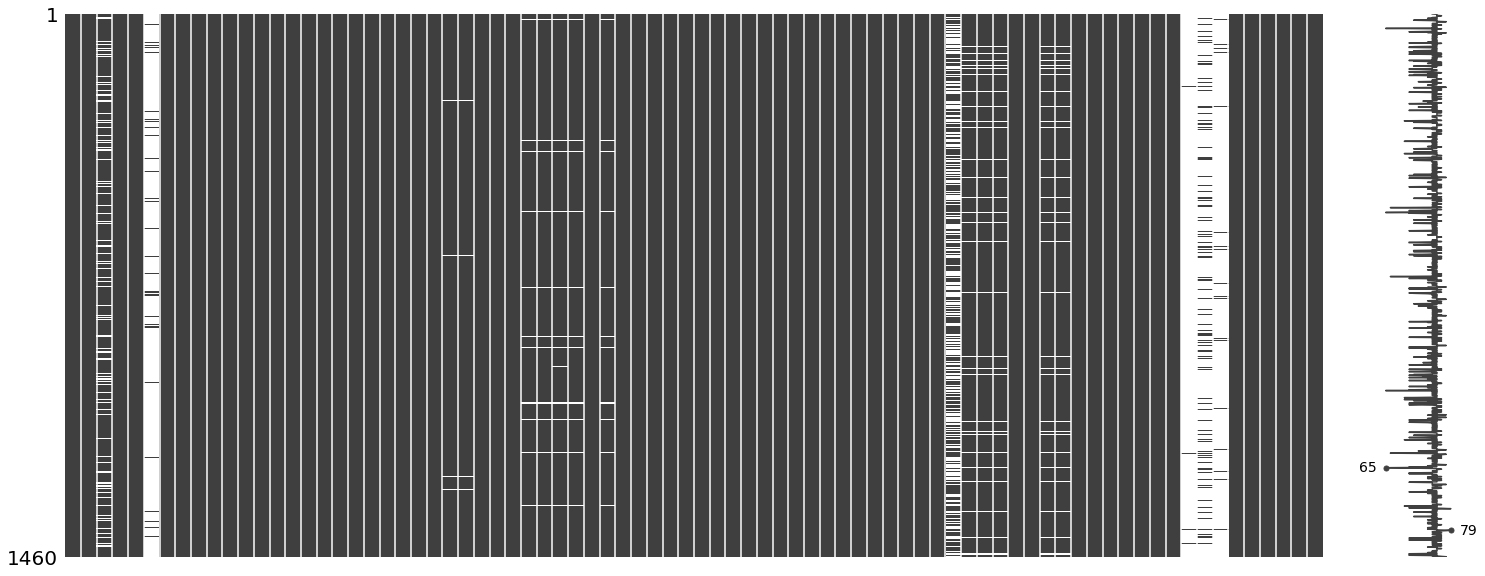

In [5]:
msno.matrix(house_data)
plt.show()

Seems like there are some features with mostly missing values  
in the training data.

For model training I will try to impute the missing values.  
For now lets also check the missing values in the testing set  
because this will influence how I am going to build the ML  
pipeline later.

In [6]:
missing_data = house_data.isna().sum()
missing_data = pd.Series(missing_data[missing_data > 0])
percent_miss = (missing_data / house_data.shape[0]).sort_values(ascending=False)
missing_train = pd.DataFrame(
    {"Missing train": (missing_data / house_data.shape[0]).sort_values(ascending=False)}
)

missing_test_data = test_data.isna().sum()
missing_test_data = pd.Series(missing_test_data[missing_test_data > 0])
missing_test = pd.DataFrame(
    {
        "Missing test": (missing_test_data / test_data.shape[0]).sort_values(
            ascending=False
        )
    }
)
missing_both = pd.merge(
    missing_train, missing_test, how="outer", left_index=True, right_index=True
).fillna(0)
missing_both.sort_values("Missing train", ascending=False).style.format("{:.2%}").bar(
    vmin=0, vmax=1
)

,Missing train,Missing test
PoolQC,99.52%,99.79%
MiscFeature,96.30%,96.50%
Alley,93.77%,92.67%
Fence,80.75%,80.12%
FireplaceQu,47.26%,50.03%
LotFrontage,17.74%,15.56%
GarageYrBlt,5.55%,5.35%
GarageQual,5.55%,5.35%
GarageFinish,5.55%,5.35%
GarageCond,5.55%,5.35%


The training data has extra columns with missing values  
also it is might happen that data in the future will also  
contain values that are missing, so the pipeline I make  
will have to take this into account.

In [7]:
print(
    f"Train duplicates: {house_data.duplicated().sum()}\nTest duplicates: {test_data.duplicated().sum()}"
)

Train duplicates: 0
Test duplicates: 0


# Data exploration

In [8]:
numeric = house_data.select_dtypes(np.number).columns
categorical = house_data.select_dtypes("object").columns

## Categorical data

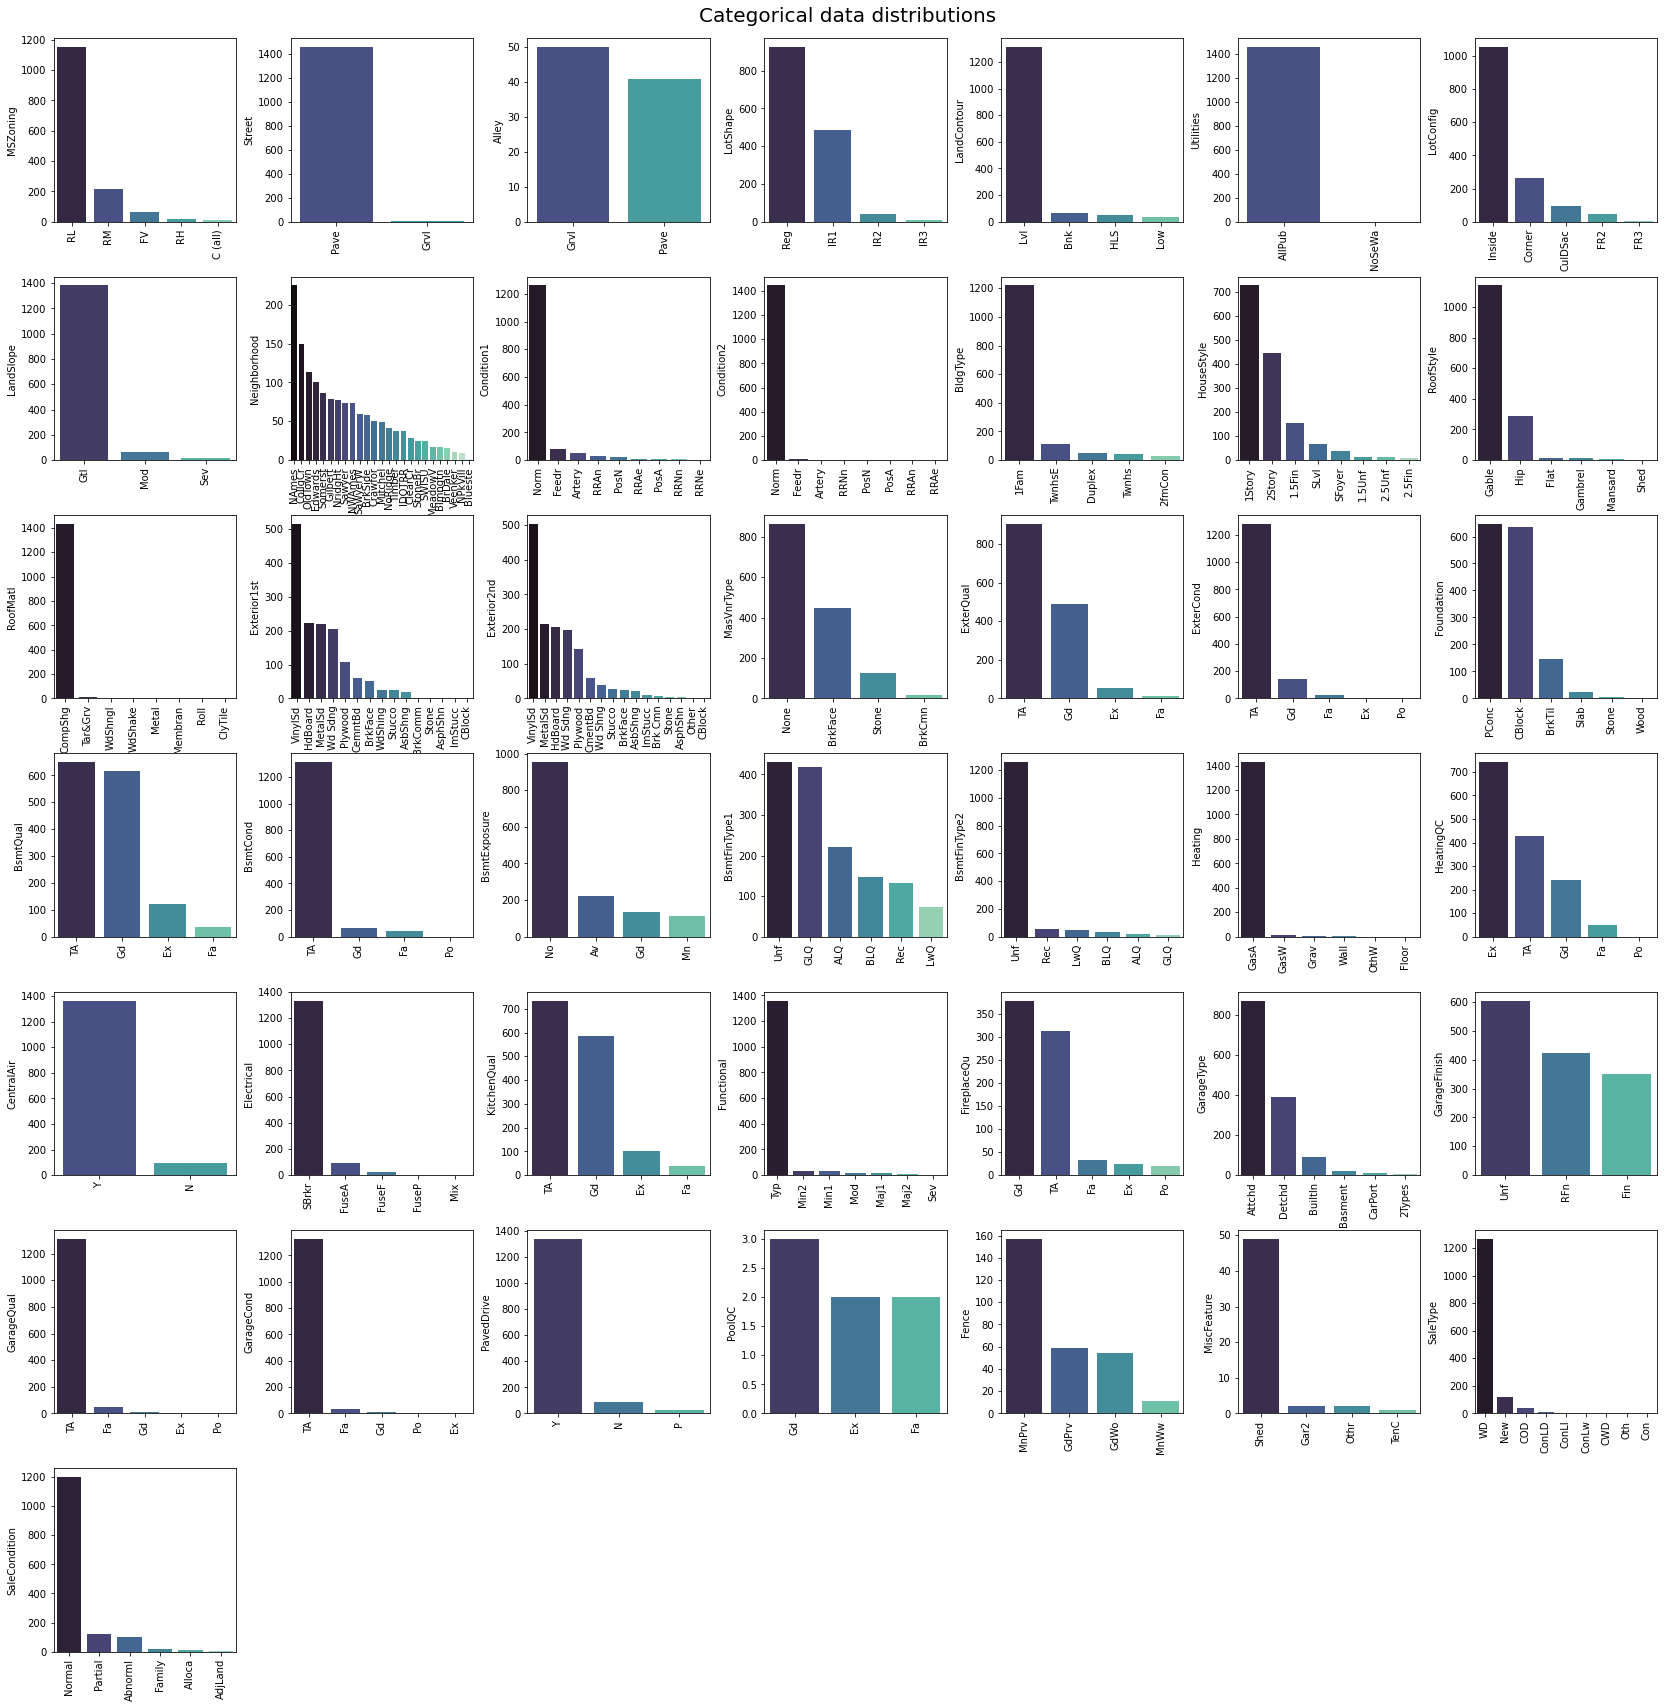

In [9]:
fig, ax = plt.subplots(7, 7, figsize=(23, 23))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, cat in enumerate(categorical):
    sns.barplot(
        data=pd.DataFrame(house_data[cat].value_counts()).reset_index(),
        x="index",
        y=cat,
        ax=ax.flatten()[idx],
        palette="mako",
    )
for axi in ax.flatten()[:-6]:
    axi.set_xticklabels(axi.get_xticklabels(), rotation=90)
    axi.set_xlabel("")
for axi in ax.flatten()[-6:]:
    fig.delaxes(axi)

plt.suptitle("Categorical data distributions", fontsize=20, y=1.01)
plt.show()

Most categorical variables have more than two classes,  
with one class usually dominating with respect to others.

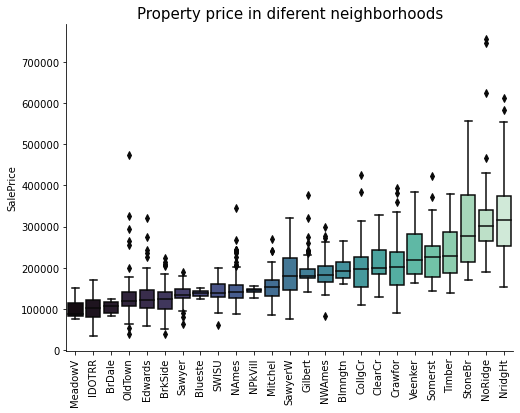

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
order = house_data.groupby("Neighborhood")["SalePrice"].median().sort_values().index

ax = sns.boxplot(
    data=house_data, x="Neighborhood", y="SalePrice", palette="mako", order=order
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Property price in diferent neighborhoods", fontsize=15)
ax.set_xlabel("")
sns.despine()
plt.show()

Some neighborhoods have a lot higher prices than others.

## Numerical data

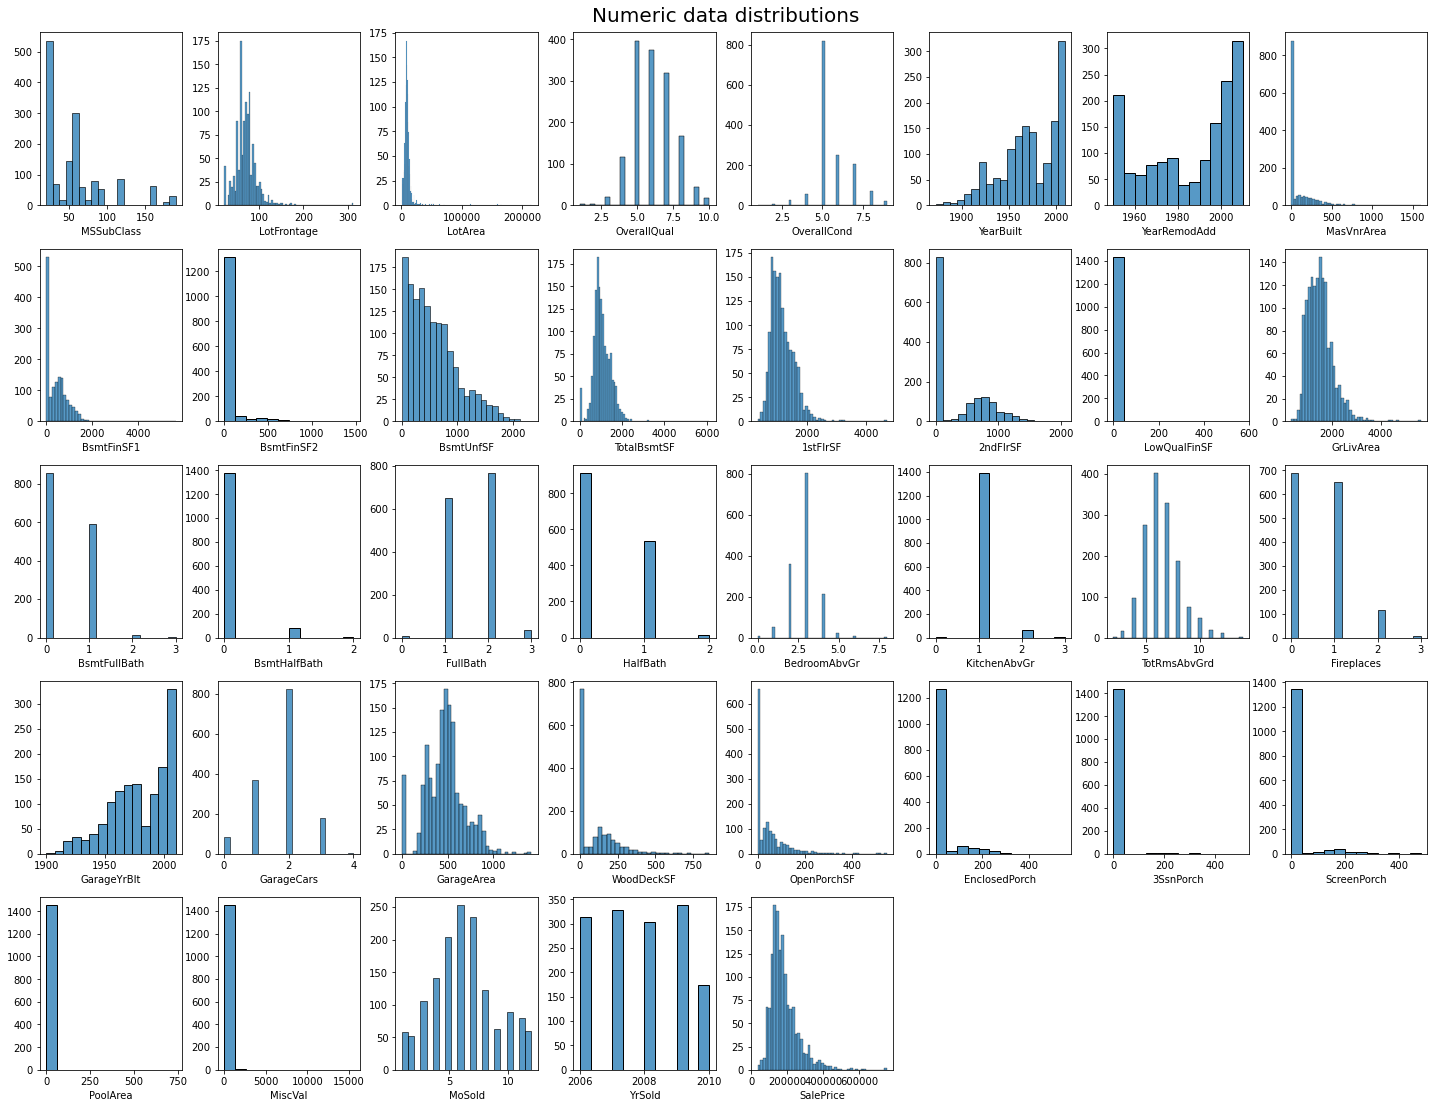

In [11]:
fig, ax = plt.subplots(5, 8, figsize=(20, 15))
fig.tight_layout()
fig.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25
)

for idx, cat in enumerate(numeric):
    sns.histplot(
        data=house_data[cat],
        ax=ax.flatten()[idx],
        palette="mako",
    )
for axi in ax.flatten()[:-3]:
    axi.set_ylabel("")
for axi in ax.flatten()[-3:]:
    fig.delaxes(axi)

plt.suptitle("Numeric data distributions", fontsize=20, y=1.01)
plt.show()

Most categories seem to be distributed non normally,  
to be sure lets check it using  Shapiro-Wilk test.

In [12]:
def check_normality(data: pd.DataFrame) -> list[str]:
    normal = []
    for col in data.columns:
        _, p_val = stats.shapiro(data[col])
        if p_val > 0.05:
            normal.append(col)
    return normal


check_normality(house_data[numeric])

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Only three features are normal, though I have  
doubts about `GarageYrBlt` being normal.

## Correlations

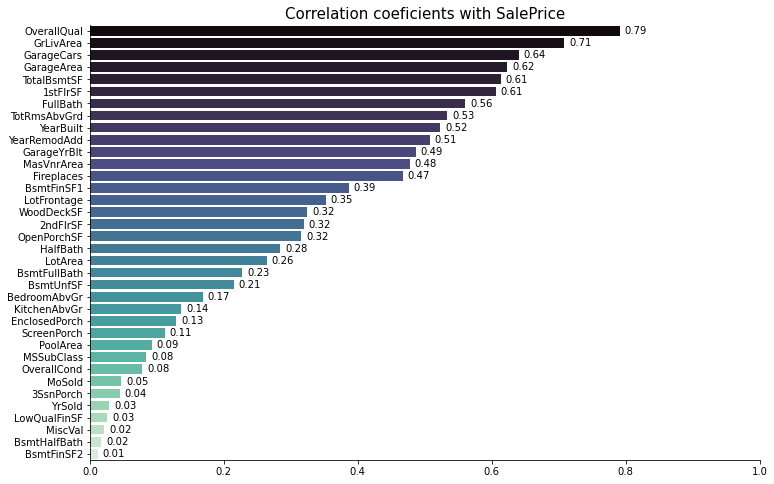

In [13]:
feat_corr = house_data[numeric].corr()["SalePrice"].abs().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(
    x=feat_corr.values[1:], y=feat_corr.index[1:], palette="mako", orient="h"
)
hori_annot(ax, 2)
ax.set_title("Correlation coeficients with SalePrice", fontsize=15)
ax.set_xlim(0, 1)
sns.despine()
plt.show()

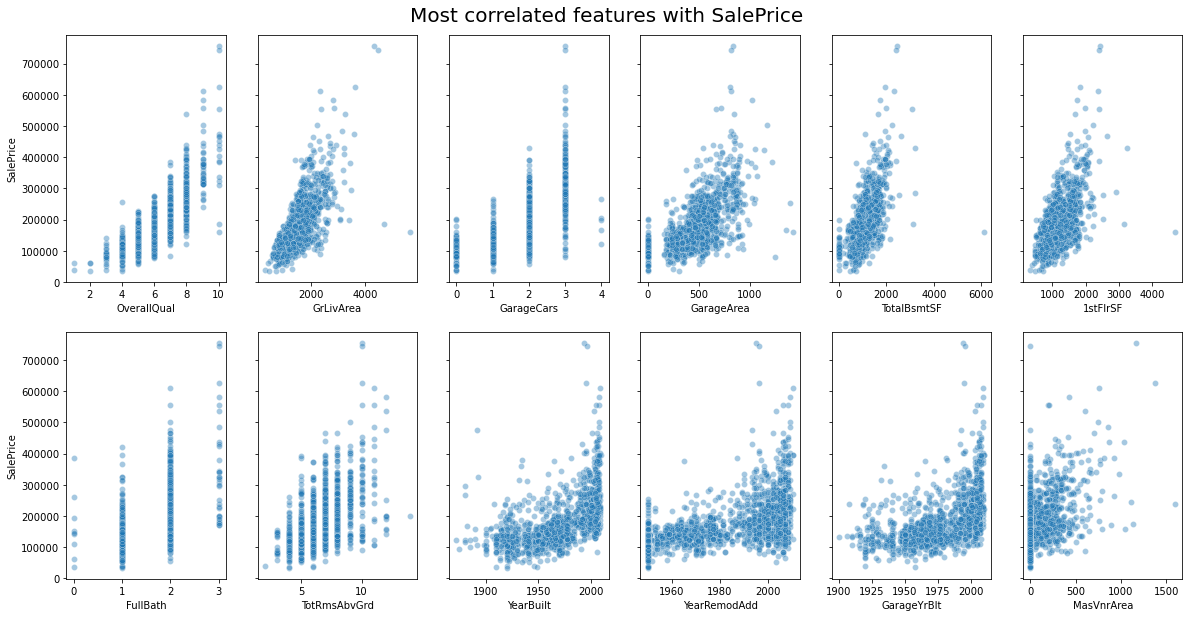

In [14]:
fig, ax = plt.subplots(2, 6, figsize=(20, 10), sharey=True)

for idx, col in enumerate(feat_corr[1:13].index):
    sns.scatterplot(
        x=house_data[col],
        y=house_data["SalePrice"],
        ax=ax.flatten()[idx],
        alpha=0.4,
    )

ax.flatten()[1]
plt.suptitle("Most correlated features with SalePrice", fontsize=20, y=0.92)
plt.show()

The most correlated feature is `OverallQual` closely followed  
by `GrLivArea` which is the livable area above ground. Overall  
most highly correlated features have something to do with livable  
area. There also might be two outliers in the ground livable area  
with very large area but low price, I will drop them.

# ML models

## Data preparations

In [15]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import joblib

In [16]:
house_data[house_data["GrLivArea"] > 4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [17]:
house_data = house_data.drop([524, 1299])

Removed the two outliers with low price and large area  
I mentioned before.

In [18]:
y = house_data["SalePrice"].copy()
y = np.log(y)
X = house_data.drop("SalePrice", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.95, stratify=X["OverallQual"], random_state=42
)

For some features missing values simply indicate the absence of  
that feature, so for these I will fill `nan` values with `0` if numeric  
and `'missing_value'` if categorical, using `SimpleImputer`.  
In other cases for numeric values I will fill with the `median`    
or the `mode` for categorical data.

In [19]:
numeric = X_train.select_dtypes(np.number).columns
categorical = X_train.select_dtypes("object").columns

# Features to be filled with constant values
fill_na_const = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "GarageYrBlt",
    "GarageArea",
    "GarageCars",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "BsmtFullBath",
    "BsmtHalfBath",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "MasVnrType",
    "MasVnrType",
    "Functional",
    "MSSubClass",
]

# Separating categorical and numerical data to be filled with constant
# values or imputed values, also sorting output lists, as sets have
# arbitraty ordering that migh change when restarting the kernel,
# this would mess with model analysis later on as models are loded from
# previous runs.
fill_na_const_num = sorted(list(set(fill_na_const) - set(categorical)))
fill_na_const_cat = sorted(list(set(fill_na_const) - set(numeric)))
fill_na_num = sorted(list(set(numeric) - set(fill_na_const_num)))
fill_na_cat = sorted(list(set(categorical) - set(fill_na_const_cat)))

# Creating categories lists for encodings, adding 'misisng_value'
# to categories to be filled with constant values
cats_const = [
    [i for i in house_data[col].unique() if i is not np.nan]
    for col in fill_na_const_cat
]
cats_const = [list + ["missing_value"] for list in cats_const]
cats = [[i for i in house_data[col].unique() if i is not np.nan] for col in fill_na_cat]

const_imputer = SimpleImputer(strategy="constant")
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")

# For simplicity transforming all numeric data to a normal distribution
# with QuantileTransformer
const_num_pipe = Pipeline(
    [
        ("imp_num", const_imputer),
        ("trans", QuantileTransformer(output_distribution="normal")),
    ]
)
num_pipe = Pipeline(
    [
        ("imp_num", num_imputer),
        ("trans", QuantileTransformer(output_distribution="normal")),
    ]
)
const_cat_pipe = Pipeline(
    [
        ("imp_cat", const_imputer),
        ("trans", OneHotEncoder(categories=cats_const)),
    ]
)
cat_pipe = Pipeline(
    [
        ("imp_cat", cat_imputer),
        ("trans", OneHotEncoder(categories=cats)),
    ]
)

col_transformers = ColumnTransformer(
    [
        ("const_num", const_num_pipe, fill_na_const_num),
        ("num", num_pipe, fill_na_num),
        ("const_cat", const_cat_pipe, fill_na_const_cat),
        ("cat", cat_pipe, fill_na_cat),
    ]
)

## Linear regression

In [20]:
lin_reg = Pipeline(
    [
        ("trans", col_transformers),
        ("reg", ElasticNet(max_iter=10_000)),
    ]
)

reg_params = {
    "reg__l1_ratio": stats.uniform(0, 1),
    "reg__alpha": stats.loguniform(1e-3, 1e3),
}

lin_reg_search = RandomizedSearchCV(
    lin_reg, reg_params, scoring="neg_root_mean_squared_error", n_iter=1000, n_jobs=-1
)

Fitting a regularized linear regression, searching for good  
regularization constant and l1/l2 regularization mix.

In [ ]:
# lin_reg_search.fit(X_train, y_train)
# joblib.dump(lin_reg_search, "lin_reg2.dump")
lin_reg_search = joblib.load("lin_reg2.dump")

In [22]:
pd.DataFrame(lin_reg_search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,param_reg__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
532,0.398132,0.032303,0.058958,0.006750,0.001167,0.367719,"{'reg__alpha': 0.0011666473841147492, 'reg__l1...",-0.116742,-0.104128,-0.114527,-0.119140,-0.110289,-0.112965,0.005293,1
651,0.354251,0.029843,0.052513,0.002772,0.001494,0.31066,"{'reg__alpha': 0.0014937926486860915, 'reg__l1...",-0.116705,-0.104520,-0.115121,-0.118560,-0.110409,-0.113063,0.005055,2
319,0.429055,0.029619,0.060673,0.003813,0.001399,0.355526,"{'reg__alpha': 0.0013988252460090092, 'reg__l1...",-0.116748,-0.104610,-0.115217,-0.118443,-0.110465,-0.113097,0.005007,3
720,0.463480,0.024124,0.061377,0.008835,0.001153,0.230397,"{'reg__alpha': 0.0011533829910133978, 'reg__l1...",-0.116976,-0.103793,-0.114096,-0.120017,-0.110626,-0.113102,0.005597,4
982,0.445229,0.036531,0.059051,0.002718,0.001451,0.199293,"{'reg__alpha': 0.0014512476793645975, 'reg__l1...",-0.116944,-0.104074,-0.114474,-0.119617,-0.110429,-0.113108,0.005436,5


### Linear regression model analysis

In [23]:
best_reg = lin_reg_search.best_estimator_

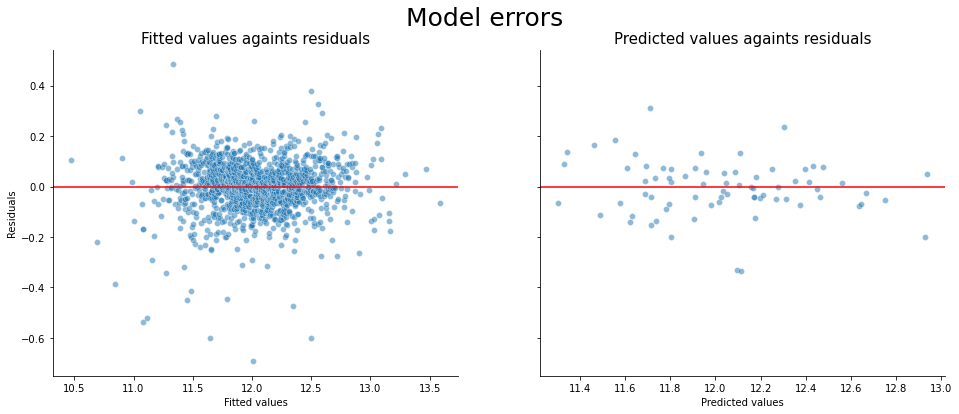

In [24]:
y_sort_train = y_train.sort_values()
x_sort_train = X_train.reindex(y_sort_train.index)
y_sort_test = y_test.sort_values()
x_sort_test = X_test.reindex(y_sort_test.index)

fitted = best_reg.predict(x_sort_train)
errors_fit = y_sort_train - fitted
prediction = best_reg.predict(x_sort_test)
errors_pred = y_sort_test - prediction
plot_compare_residuals(fitted, errors_fit, prediction, errors_pred)

plt.suptitle("Model errors", fontsize=25)
plt.show()

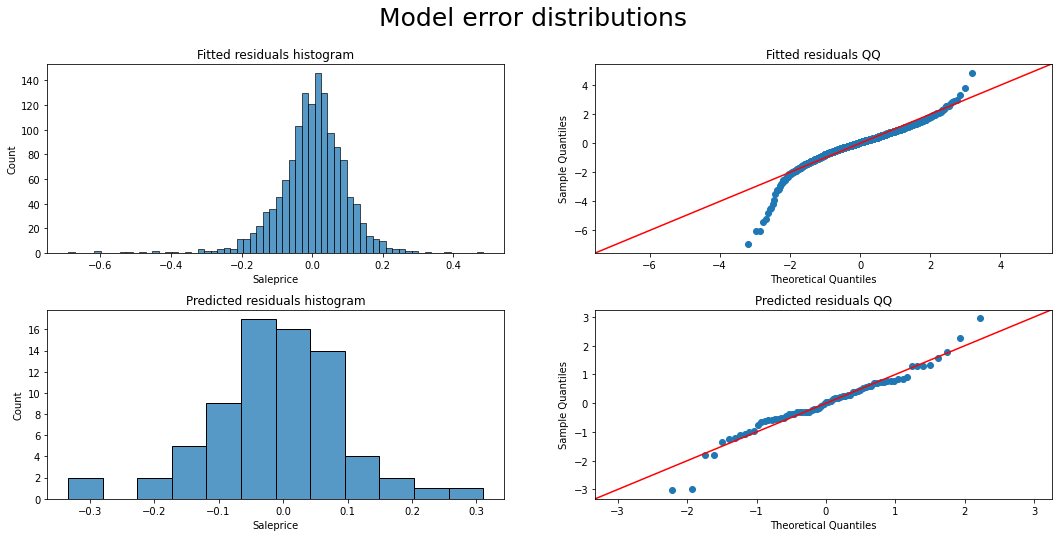

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
fig.subplots_adjust(hspace=0.3)
plt.suptitle("Model error distributions", fontsize=25)
plot_hist(errors_fit, ax[0][0], "Fitted residuals histogram")
plot_qq(errors_fit, ax[0][1], "Fitted residuals QQ")
plot_hist(errors_pred, ax[1][0], "Predicted residuals histogram")
plot_qq(errors_pred, ax[1][1], "Predicted residuals QQ")

The errors the model made were even larger on the training set,  
but this might be explained by the small size of the dataset used  
for testing. 

The errors form the linear regression model also distributed not quite  
normally and have outliers especially with some predictions overestimating  
the price.

In [26]:
print(
    "Root mean squared errors for fitted values",
    round(rmse(fitted, y_sort_train), 4),
)
print(
    "Root mean squared errors for predicted values",
    round(rmse(prediction, y_sort_test), 4),
)

Root mean squared errors for fitted values 0.0994
Root mean squared errors for predicted values 0.108


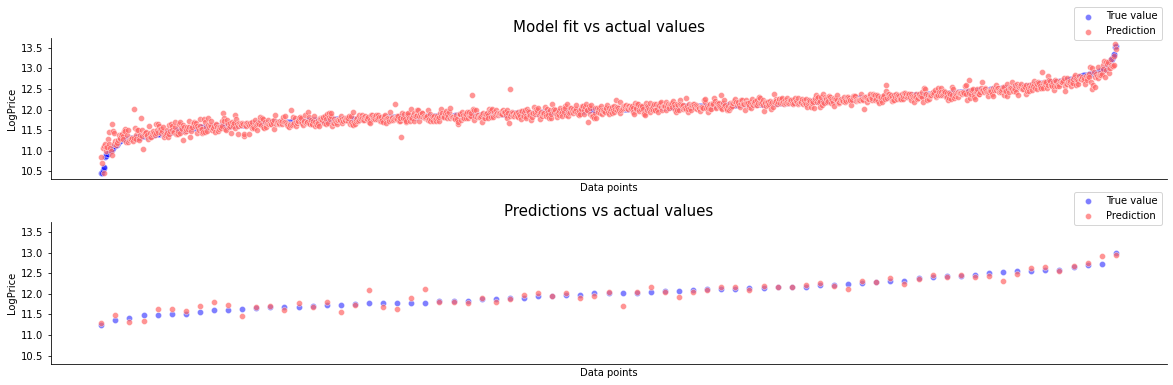

In [27]:
plot_compare_reg(fitted, y_sort_train, prediction, y_sort_test, "LogPrice")
plt.show()

Overall the model seems to fit the data pretty well.

Lets look at the models coefficients and which features  
were important.

In [28]:
names = (
    fill_na_const_num
    + fill_na_num
    + [
        col + "_" + name
        for idx, col in enumerate(fill_na_const_cat)
        for name in cats_const[idx]
    ]
    + [col + "_" + name for idx, col in enumerate(fill_na_cat) for name in cats[idx]]
)

In [29]:
pos_coefs = pd.DataFrame(
    best_reg["reg"].coef_.reshape(-1, 1), index=names, columns=["coef"]
)
pos_coefs[(pos_coefs["coef"] > 0) | (pos_coefs["coef"] < 0)].sort_values(
    "coef", key=abs, ascending=False
).head(20).style.format("{:.3f}")

,coef
MSZoning_C (all),-0.277
GrLivArea,0.113
Neighborhood_Crawfor,0.097
Neighborhood_StoneBr,0.088
Functional_Typ,0.071
Functional_Maj2,-0.067
Neighborhood_NoRidge,0.060
KitchenQual_Ex,0.056
Exterior1st_BrkFace,0.055
OverallQual,0.054


As expected living area plays a large role, also  
neighborhoods have both positive and negative  
influence on the price of the properties.

In [30]:
ans = pd.DataFrame(
    zip(test_data.index, np.exp(lin_reg_search.predict(test_data))),
    columns=["Id", "SalePrice"],
)
ans.set_index("Id").to_csv("lin_reg.csv")
ans.head().style.format({"SalePrice": "{:.2f}$"})

,Id,SalePrice
0,1461,121059.47$
1,1462,155750.44$
2,1463,185813.20$
3,1464,197661.99$
4,1465,191658.50$


The model achieved a score of 0.12789 in the competition.

## Random forest regression

Now lets try the same but with a random forest model.

For random forest I will be modifying the pipelines to  
`OrdinalEncodesr` instead of `OneHotEncoder`, it makes  
the model train faster and also improves the score of  
the model, because you are not training trees on sparse  
data.

In [31]:
const_cat_pipe_for = Pipeline(
    [("imp_cat", const_imputer), ("trans", OrdinalEncoder(categories=cats_const))]
)

cat_pipe_for = Pipeline(
    [
        ("imp_cat", cat_imputer),
        ("trans", OrdinalEncoder(categories=cats)),
    ]
)

col_transformers = ColumnTransformer(
    [
        ("const_num", const_num_pipe, fill_na_const_num),
        ("num", num_pipe, fill_na_num),
        ("const_cat", const_cat_pipe_for, fill_na_const_cat),
        ("cat", cat_pipe_for, fill_na_cat),
    ]
)

rand_for = Pipeline(
    [
        ("trans", col_transformers),
        ("reg", RandomForestRegressor(random_state=42)),
    ]
)

param_grid = {
    "reg__n_estimators": stats.randint(100, 1000),
}


rand_for_search = RandomizedSearchCV(
    rand_for, param_grid, scoring="neg_root_mean_squared_error", n_iter=50, n_jobs=-1
)

In [ ]:
# rand_for_search.fit(X_train, y_train)
# joblib.dump(rand_for_search, "rand_for.dump")
rand_for_search = joblib.load("rand_for.dump")

In [33]:
pd.DataFrame(rand_for_search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,23.831315,0.883589,0.238727,0.012933,971,{'reg__n_estimators': 971},-0.145159,-0.132182,-0.132727,-0.141648,-0.143013,-0.138946,0.005420,1
10,20.190546,0.169707,0.321122,0.059387,679,{'reg__n_estimators': 679},-0.144793,-0.132176,-0.132802,-0.142105,-0.142886,-0.138953,0.005353,2
45,18.929594,0.417271,0.259631,0.054968,691,{'reg__n_estimators': 691},-0.144774,-0.132132,-0.132860,-0.142074,-0.142950,-0.138958,0.005353,3
20,23.300401,0.155939,0.234526,0.013350,939,{'reg__n_estimators': 939},-0.145263,-0.132137,-0.132763,-0.141704,-0.142970,-0.138967,0.005446,4
27,16.304411,0.347573,0.215097,0.047633,697,{'reg__n_estimators': 697},-0.144829,-0.132138,-0.132844,-0.142062,-0.142971,-0.138969,0.005369,5


### Random forest regression model analysis

In [34]:
best_reg = rand_for_search.best_estimator_

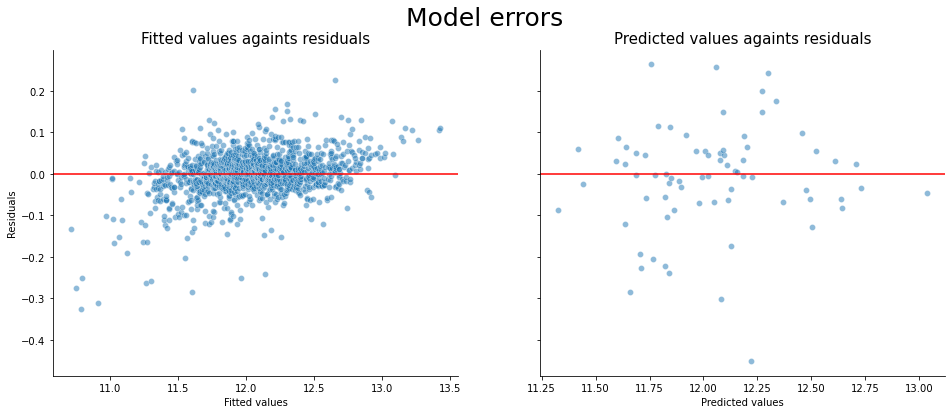

In [35]:
y_sort_train = y_train.sort_values()
x_sort_train = X_train.reindex(y_sort_train.index)
y_sort_test = y_test.sort_values()
x_sort_test = X_test.reindex(y_sort_test.index)

fitted = best_reg.predict(x_sort_train)
errors_fit = y_sort_train - fitted
prediction = best_reg.predict(x_sort_test)
errors_pred = y_sort_test - prediction
plot_compare_residuals(fitted, errors_fit, prediction, errors_pred)

plt.suptitle("Model errors", fontsize=25)
plt.show()

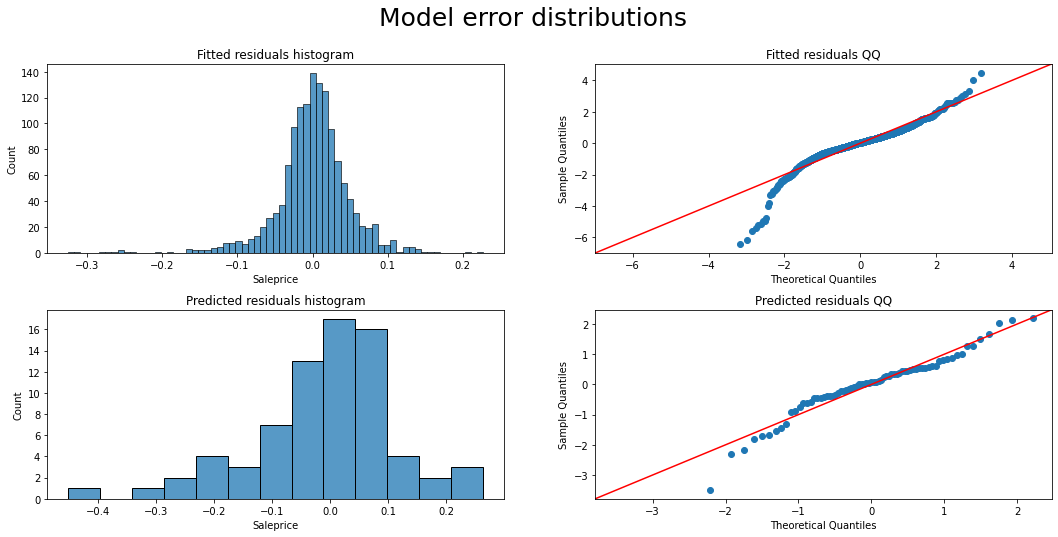

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
fig.subplots_adjust(hspace=0.3)
plt.suptitle("Model error distributions", fontsize=25)
plot_hist(errors_fit, ax[0][0], "Fitted residuals histogram")
plot_qq(errors_fit, ax[0][1], "Fitted residuals QQ")
plot_hist(errors_pred, ax[1][0], "Predicted residuals histogram")
plot_qq(errors_pred, ax[1][1], "Predicted residuals QQ")

The errors from Random Forrest fallow a similar trend to Linear regression,  
with overestimates being more common, but the rmse scores also show that  
the this model might be overfitting the data.

In [37]:
print(
    "Root mean squared errors for fitted values",
    round(rmse(fitted, y_sort_train), 4),
)
print(
    "Root mean squared errors for predicted values",
    round(rmse(prediction, y_sort_test), 4),
)

Root mean squared errors for fitted values 0.0506
Root mean squared errors for predicted values 0.1261


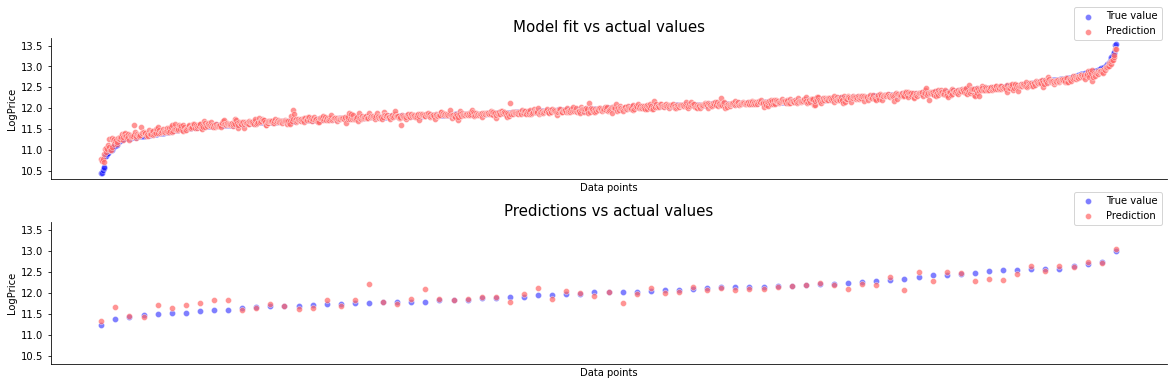

In [38]:
plot_compare_reg(fitted, y_sort_train, prediction, y_sort_test, "LogPrice")
plt.show()

In [39]:
names = fill_na_const_num + fill_na_num + fill_na_const_cat + fill_na_cat

rand_for_imp = pd.DataFrame(
    rand_for_search.best_estimator_["reg"].feature_importances_.reshape(-1, 1),
    index=names,
    columns=["coef"],
).sort_values("coef", ascending=False)

In [40]:
rand_for_imp.head(10).style.format("{:.3f}")

,coef
OverallQual,0.554
GrLivArea,0.111
TotalBsmtSF,0.050
GarageCars,0.036
GarageArea,0.026
1stFlrSF,0.024
BsmtFinSF1,0.021
YearBuilt,0.017
LotArea,0.014
OverallCond,0.010


In [41]:
rand_for_imp.tail(10).style.format("{:.3e}")

,coef
MiscFeature,1.451e-04
MiscVal,1.404e-04
Heating,1.251e-04
3SsnPorch,9.404e-05
Street,8.639e-05
RoofMatl,8.478e-05
Condition2,8.141e-05
PoolArea,2.903e-05
PoolQC,2.601e-05
Utilities,2.084e-06


The most important features for random forest are  
also the features that had the highest correlation  
with SalePrice, so the living area and the quality  
are very important predictors of price.

In [42]:
ans = pd.DataFrame(
    zip(test_data.index, np.exp(rand_for_search.predict(test_data))),
    columns=["Id", "SalePrice"],
)
ans.set_index("Id").to_csv("rand_for.csv")
ans.head().style.format({"SalePrice": "{:.2f}$"})

,Id,SalePrice
0,1461,125869.24$
1,1462,152953.86$
2,1463,176523.93$
3,1464,179919.24$
4,1465,195422.21$


Random forest achieved a score of 0.14567 in the competition.

# Summary

The total livable area, the neighborhood and the quality of the property are the most  
important factors that determine the price of property.

The regularized linear regression model performed better than the random forest.  

To improve the random forest model we could experiment with reducing the number of  
features each tree sees or limit the depth of the trees, we could also try extra  
random trees to reduce variance.